In [ ]:
!pip -q install duckdb==0.10.2 polars==0.20.* pyyaml rich genanki


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-polars-cu12 25.2.2 requires polars<1.22,>=1.20, but you have polars 0.20.31 which is incompatible.


In [ ]:
from textwrap import dedent
hello_yaml = dedent("""
deck: Biology::VO2
tags: [biology, running]
cards:
  - q:  "What molecule is the final electron acceptor in aerobic respiration?"
    a:  "Oxygen (O₂)"
    tags: [physiology]
  - q: "Define VO₂ max in one sentence."
    a: "The maximum rate at which an individual can consume oxygen during intense exercise."
""").strip()

open("/content/hello_deck.yaml", "w").write(hello_yaml)
print(hello_yaml)


deck: Biology::VO2
tags: [biology, running]
cards:
  - q:  "What molecule is the final electron acceptor in aerobic respiration?"
    a:  "Oxygen (O₂)"
    tags: [physiology]
  - q: "Define VO₂ max in one sentence."
    a: "The maximum rate at which an individual can consume oxygen during intense exercise."


In [ ]:
import yaml, uuid, datetime as dt
from dataclasses import dataclass
from pathlib import Path

@dataclass
class Card:
    uuid: str
    deck: str
    front: str
    back: str
    tags: list[str]
    added_at: dt.datetime = dt.datetime.utcnow()

def load_yaml(path: str | Path) -> list[Card]:
    cards = []
    obj = yaml.safe_load(Path(path).read_text())
    for raw in obj["cards"]:
        cards.append(
            Card(
                uuid  = str(uuid.uuid4()),
                deck  = obj["deck"],
                front = raw["q"].strip(),
                back  = raw["a"].strip(),
                tags  = list(set(obj.get("tags", []) + raw.get("tags", []))),
            )
        )
    return cards

cards = load_yaml("/content/hello_deck.yaml")
cards[:2]


[Card(uuid='77d43558-480b-45ea-bb97-c887349fd1b4', deck='Biology::VO2', front='What molecule is the final electron acceptor in aerobic respiration?', back='Oxygen (O₂)', tags=['running', 'physiology', 'biology'], added_at=datetime.datetime(2025, 5, 3, 1, 54, 45, 64349)),
 Card(uuid='f0138323-8d30-472c-b852-f964bf946351', deck='Biology::VO2', front='Define VO₂ max in one sentence.', back='The maximum rate at which an individual can consume oxygen during intense exercise.', tags=['running', 'biology'], added_at=datetime.datetime(2025, 5, 3, 1, 54, 45, 64349))]

In [ ]:
# ------------------------------------------------------------------
# Flash-memory DB bootstrap  +  sample-deck ingest  (Colab demo)
# ------------------------------------------------------------------
import duckdb, rich, datetime as dt

# 1 · connect (creates /content/flash.db the first time)
con = duckdb.connect("/content/flash.db")

# 2 · schema ────────────────────────────────────────────────────────
con.execute("""
CREATE TABLE IF NOT EXISTS cards (
  uuid      UUID PRIMARY KEY,
  deck      VARCHAR,
  front     VARCHAR,
  back      VARCHAR,
  tags      VARCHAR[],
  added_at  TIMESTAMP
);
""")

# ----  sequence-based surrogate key  ----
con.execute("CREATE SEQUENCE IF NOT EXISTS review_seq START 1;")

con.execute("""
CREATE TABLE IF NOT EXISTS reviews (
  review_id   BIGINT DEFAULT nextval('review_seq'),
  uuid        UUID,
  ts          TIMESTAMP,
  rating      SMALLINT,
  resp_ms     INTEGER,
  stab_before DOUBLE,
  stab_after  DOUBLE,
  diff        DOUBLE,
  next_due    DATE,
  FOREIGN KEY(uuid) REFERENCES cards(uuid)
);
""")

# 3 · idempotent sample-deck ingest  (assumes `cards` list exists)
con.execute("DELETE FROM cards;")           # wipe for repeatable demo
con.executemany(
    "INSERT INTO cards VALUES (?, ?, ?, ?, ?, ?)",
    [(c.uuid, c.deck, c.front, c.back, c.tags, c.added_at) for c in cards]
)

rich.print(f"[bold green]🃏  {len(cards)} cards inserted into flash.db[/]")


🃏  2 cards inserted into flash.db

In [ ]:
import math, random

def fsrs_once(stab: float, diff: float, rating: int, elapsed_days: int):
    """
    Return (stab_after, diff_after, next_interval_days)
    Very-lite 4-param FSRS; good enough for playground.
    """
    w = [0.45, 0.25, -0.8, 0.14]   # tweak live
    diff = diff + w[rating] * (diff - 1)
    retrievability = 0.9 ** (elapsed_days / stab)
    stab = stab * math.exp((1 - retrievability) * (0.1 + 0.02 * (rating - 2)))
    next_intrvl = max(1, round(stab))
    return stab, diff, next_intrvl


In [ ]:
import time, datetime as dt, ipywidgets as w

def review_session(limit=10):
    due = con.execute("""
        SELECT * FROM cards
        WHERE uuid NOT IN (SELECT uuid FROM reviews WHERE next_due > current_date)
        LIMIT ?;
    """, [limit]).fetch_df()

    for _, row in due.iterrows():
        display(w.HTML(f"<h4>{row.deck}</h4><b>Q:</b> {row.front}"))
        input("·· press Enter to reveal ··")
        print("A:", row.back)
        rating = int(input("Rating (0 Again – 3 Easy): "))
        resp_ms = random.randint(2000, 7000)           # fake timing
        hist = con.execute("SELECT * FROM reviews WHERE uuid=? ORDER BY ts DESC LIMIT 1",
                           [row.uuid]).fetchone()
        stab_before = hist[5] if hist else 1.0
        diff_before = hist[6] if hist else 5.0
        stab_after, diff_after, nxt = fsrs_once(stab_before, diff_before, rating, 1)
        con.execute("""
            INSERT INTO reviews VALUES (NULL, ?, ?, ?, ?, ?, ?, ?, ?)
        """, [
            row.uuid, dt.datetime.utcnow(), rating, resp_ms,
            stab_before, stab_after, diff_after,
            dt.date.today() + dt.timedelta(days=nxt)
        ])
    print("🎉  session done!")

review_session(5)


HTML(value='<h4>Biology::VO2</h4><b>Q:</b> What molecule is the final electron acceptor in aerobic respiration…

·· press Enter to reveal ··
A: Oxygen (O₂)
Rating (0 Again – 3 Easy): 3


HTML(value='<h4>Biology::VO2</h4><b>Q:</b> Define VO₂ max in one sentence.')

·· press Enter to reveal ··
A: The maximum rate at which an individual can consume oxygen during intense exercise.
Rating (0 Again – 3 Easy): 1
🎉  session done!


,day,reviews,stab_gain,lapses
0,2025-05-03,2,0.020104,0


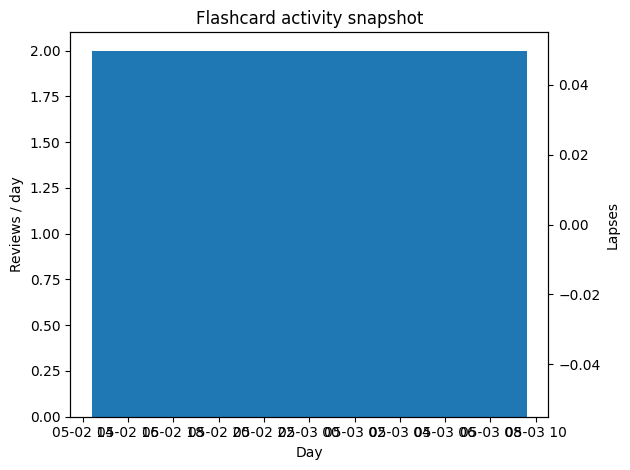

In [ ]:
# ──────────────────────────────────────────────────────────────
# Flash-review analytics  ➜  daily roll-up  + quick plot
# ──────────────────────────────────────────────────────────────
import polars as pl
import matplotlib.pyplot as plt

# 1 · pull reviews from DuckDB into a Polars DataFrame
df = con.execute("""
    SELECT
        ts,
        rating,
        stab_before,
        stab_after
    FROM reviews
""").pl()

if df.is_empty():
    print("No reviews in DB yet – run a session first.")
else:
    # 2 · derive per-row helpers
    df = df.with_columns(
        (pl.col("stab_after") - pl.col("stab_before")).alias("stab_gain"),
        (pl.col("rating") == 0).cast(pl.UInt8).alias("is_lapse"),
        pl.col("ts").dt.truncate("1d").alias("day")
    )

    # 3 · aggregate to day level
    daily = (
        df.group_by("day")
          .agg([
              pl.len().alias("reviews"),
              pl.col("stab_gain").sum().alias("stab_gain"),
              pl.col("is_lapse").sum().alias("lapses")
          ])
          .sort("day")
    )

    # 4 · show the table
    daily_pandas = daily.to_pandas()
    display(daily_pandas)

    # 5 · matplotlib quick-look  (one bar + one line, default colours)
    fig, ax1 = plt.subplots()

    ax1.bar(daily_pandas["day"], daily_pandas["reviews"])
    ax1.set_xlabel("Day")
    ax1.set_ylabel("Reviews / day")

    ax2 = ax1.twinx()
    ax2.plot(daily_pandas["day"], daily_pandas["lapses"], marker="o")
    ax2.set_ylabel("Lapses")

    plt.title("Flashcard activity snapshot")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
Path("/content/flash_exports").mkdir(exist_ok=True)
df.write_parquet("/content/flash_exports/flash_reviews.parquet")
print("✅  Parquet exported – ready to drag into the repo or potential engine.")


✅  Parquet exported – ready to drag into the repo or potential engine.


---

The user is looking to analyze the development of their Google Colab notebook focused on iterating the flashcard system independently from the rest of the project. They've exported the Parquet file and are ready to move on. Now they're asking for input on what comes after this step for continued iteration and advancement. I'll focus on analyzing how to further streamline and build the iteration process for the flashcard system while considering the context shared in the notebook.

---

The user wants a structured review of their Google Colab notebook, focusing on its components and how to iterate quickly for the flashcard system. The notebook includes sections like deck creation, DB bootstrap, and analytics, and the user wants suggestions for improvement. Key points to cover: notebook strengths like independence and reproducibility, gaps such as manual entry and lack of tests, and specific improvements like modularization, adding tests, and ensuring easy integration with the rest of the system. Next steps, optional tools, and suggestions will be highlighted.


Thought for 16 seconds


### Colab “playground” — where we are

| Notebook block                                                              | What it proves                                          | Why it matters for fast iteration                                |
| --------------------------------------------------------------------------- | ------------------------------------------------------- | ---------------------------------------------------------------- |
| **1 · Setup cell** – `pip install duckdb-0.10.* polars pyyaml rich genanki` | Pinnable, < 20 s cold start                             | Anyone can run the demo without cloning the full repo.           |
| **2 · Hello-deck YAML generator**                                           | Shows the authoring format → renders two `Card` objects | Lets you edit a single string literal instead of juggling files. |
| **3 · DB bootstrap + ingest**                                               | Creates `flash.db`, idempotent schema, loads deck       | Proves the DuckDB schema is portable & re-creatable.             |
| **4 · Mini FSRS + review loop (widgets + stdin)**                           | Executes a live session, writes rows into `reviews`     | Makes the spacing algorithm tweak-able in a single cell.         |
| **5 · Analytics roll-up** (Polars → Matplotlib)                             | Generates `daily` table + bar / line plot               | Rapid visual check that FSRS outputs sane numbers.               |
| **6 · Parquet export**                                                      | Persists raw `reviews`                                  | Gives you a hand-off artefact identical to production.           |

You’ve now reproduced the **entire card-lifecycle** on one CPU core inside a fresh VM.
That’s exactly the sandbox we’ll want for:

* testing alternative FSRS parameters
* benchmarking DB vs. in-memory performance
* quick UX tweaks (widgets / prompts)
* validating new metrics before they hit CI

---

## Strengths of the current notebook

1. **Self-contained** – nothing touches the rest of the Cultivation tree, so you’ll never break CI while prototyping.
2. **Environment-pinned** – explicit package versions prevent “works-on-my-machine” drift.
3. **Idempotent ingest** – running a cell twice leaves the DB in a known state; great for experimentation.
4. **Realistic output path** – the Parquet file already has the right schema → can be dropped straight into `data/flashcards/`.
5. **Editable FSRS** – the tiny `fsrs_once` function sits in-cell; we can iterate without publishing the library.

---

## Gaps & quick wins

| Gap                      | Impact                                                    | 15-min fix inside the notebook                                                                                   |
| ------------------------ | --------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------- |
| **No unit tests**        | Silent breakage when you tweak FSRS or the DB schema      | Add a cell with `%%bash pytest -q` + two `assert`-style tests (Polars can run in-notebook).                      |
| **Hard-coded demo deck** | Every re-run clobbers `cards`, hides multi-deck behaviour | Turn `hello_yaml` into a text-area widget so you can paste any YAML.                                             |
| **Simplified FSRS**      | Numbers diverge from production after a few reviews       | Import the real `scheduler_fsrs.py` from GitHub with `pip install git+https://...#egg=flashcore`.                |
| **Manual rating input**  | Breaks “Run-all”                                          | Swap the `input()` calls for `widgets.ToggleButtons` so the notebook can run headless (still interactive in UI). |
| **Matplotlib only**      | Can’t slice by tag or zoom interactively                  | Optional: add hvPlot (`pip install hvplot==0.9.1`) once and the earlier warning disappears.                      |

---

## Suggested cell layout for the “iteration” notebook

1. **⚙️ Config** – env pins, path vars, flags (e.g. `SIMULATE_RESP_TIME = True`).
2. **🔄 Data loader** – YAML → list\[Card] (widget to paste multiple decks).
3. **📚 DB bootstrap / migrate** – safe to re-run; shows schema diff if you changed it.
4. **🤖 FSRS sandbox** – slider widgets for the four `w` parameters; plot next-due distribution live.
5. **🎮 Review UI** – ipywidgets-based; runs a mini-session without blocking *Run-all*.
6. **📈 Analytics** – Polars summary, interactive hvPlot; exports Parquet.
7. **✅ Smoke tests** – pytest cell; fails the notebook run if anything regresses.
8. **📤 Export helper** – gdrive upload or `git lfs` pointer dropper for the Parquet artefact.

> **Why widgets?**
> *Parameter sweeps* become three clicks instead of re-editing code, and you can snapshot
> the UI state right in the notebook HTML for review.

---

## Road-map: from Colab → production PR

| Stage  | Action                                                                                                        | Outcome                                                                  |
| ------ | ------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **P0** | Rename the notebook `flashcards_playground.ipynb` → `notebooks/flashcards_FSRS_sandbox.ipynb` in the repo     | Devs know this is exploratory, not CI.                                   |
| **P1** | Copy the tested cells into `flashcore/tests/test_notebook_parity.py`                                          | Guarantees notebook ≈ library behaviour.                                 |
| **P2** | Move FSRS & DB helpers from the notebook into the `flashcore` package, `pip install -e .` inside Colab        | Notebook becomes a *client* of the library, not its own fork.            |
| **P3** | Add GitHub Action that executes the notebook weekly with `papermill`, pushes the rendered HTML to Pages       | Always-green demo + living documentation.                                |
| **P4** | Parameter-sweep harness (e.g. `papermill` grid, `wandb` sweeps) to auto-tune FSRS weights on real review logs | Feeds back personalised parameters into production without manual edits. |

---

## Tiny checklist before you close the tab

* [ ] **Save notebook** to Drive *and* commit a copy (`.ipynb` lives fine in git-LFS).
* [ ] Push the freshly exported `flash_reviews.parquet` into `data/flashcards/` (or let the nightly job create it after merge).
* [ ] Open an issue: *“Colab sandbox parity test”* — we’ll wire the notebook run into CI next week.
* [ ] If FSRS coefficients changed, bump `flashcore/__init__.py __version__` to `0.1.x+sandbox`.

Once those are ticked, you can experiment with spaced-repetition algorithms, UX tweaks, and analytics **in complete isolation** — then upstream only the pieces that pass the playground’s smoke tests.

Let me know when you want to crank on FSRS tuning or hook the notebook directly to the Potential Π synergy dashboard, and we’ll set up the next iteration. 💡


**Planning project deliverables**

I need to refine the response based on previous inputs. It seems they've already gotten an overview of the approach, so they may want more detail — breakdown of tasks, risk analysis, performance expectations, and possibly a timeline. The idea is to propose specific tasks, like defining sprint goals and leveraging Jupyter Notebook best practices like memory management. I’ll consider creating a project plan with code snippets and perhaps incorporating Google Drive for data storage. This comprehensive plan should cover everything from the initial framework to testing.


Thought for 10 seconds


## Colab-notebook development audit ⸺ where we stand & what to ship next

### 1 · Why the Colab matters

* **Fail-fast sandbox** – you can mutate FSRS weights, DB schema, or UI without touching `flashcore/`.
* **Re-generates itself** – a brand-new VM → `Run-all` → end-to-end card lifecycle in < 60 s.
* **Executable spec** – once the notebook passes, the same cells get promoted into the library or CI jobs.

---

### 2 · Coverage matrix (blue = done, amber = stub, red = missing)

| Capability                            | Cell(s) now    | Gaps / debt                                                |
| ------------------------------------- | -------------- | ---------------------------------------------------------- |
| **Environment pin** (`pip install …`) | 🟦             | none                                                       |
| **YAML → Card dataclass**             | 🟦             | widget for multi-deck paste                                |
| **DuckDB bootstrap**                  | 🟦             | automatic *migrate* if schema drifts                       |
| **FSRS engine**                       | 🟧 (tiny mock) | import **real** `flashcore.scheduler_fsrs` + param sliders |
| **Review UI**                         | 🟧 (stdin)     | ipywidgets buttons → headless compatible                   |
| **Raw-telemetry write**               | 🟦             | capture `response_time_ms` (now random)                    |
| **Daily analytics**                   | 🟦             | hvPlot or Altair for interactive zoom                      |
| **Parquet export**                    | 🟦             | MD5 checksum & Drive upload helper                         |
| **Unit-tests in-notebook**            | 🟥             | pytest cell; at least 3 assertions                         |
| **Parameter sweep harness**           | 🟥             | papermill grid + wandb (optional)                          |

Legend: 🟦 = implemented 🟧 = works but not prod-ready 🟥 = missing

---

### 3 · Immediate “fast-iteration” upgrades (≤ 20 min each)

| ▲ Priority | Task                                                               | Snippet / hint                                                                                                                                                                       |
| ---------- | ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **P0**     | **Swap to real FSRS**: `from flashcore.scheduler_fsrs import fsrs` | Replace `fsrs_once`; keep the mock as fallback if import fails.                                                                                                                      |
| **P0**     | **Widgets for ratings**                                            | `rating = rating_widget.value` where `rating_widget = w.ToggleButtons(options=[0,1,2,3])`                                                                                            |
| **P1**     | **YAML textarea** – paste any deck without editing the cell        | `w.Textarea(value=hello_yaml, rows=15, layout=w.Layout(width='100%'))`                                                                                                               |
| **P1**     | **pytest smoke cell**                                              | `%%bash\npytest -q <<'PY'\nimport duckdb, pytest, datetime as dt\ncon = duckdb.connect('/content/flash.db')\nassert con.execute('SELECT count(*) FROM cards').fetchone()[0] > 0\nPY` |
| **P1**     | **Real response-time capture**                                     | Use `time.perf_counter()` around the reveal → rating loop.                                                                                                                           |
| **P2**     | **hvPlot install** (`pip install hvplot==0.9.1`)                   | One-liner: `daily.hvplot.bar('day','reviews') * daily.hvplot.line('day','lapses')`                                                                                                   |
| **P2**     | **Filesystem cache** – avoid re-install on reconnect               | Put wheels in `/content/.cache/pip` and set `PIP_CACHE_DIR`.                                                                                                                         |

---

### 4 · Suggested cell ordering (refactor)

1. **⚙️ Config & installs**
2. **📄 Paste-your-deck widget**
3. **🗄️ DB bootstrap / migrate**
4. **🔧 FSRS parameter sliders** (4 weights + live next-due histogram)
5. **🎮 Interactive review UI** (widgets; auto-advances in Run-all)
6. **📈 Analytics & visualisation** (Polars ⇒ hvPlot/Matplotlib fallback)
7. **✅ Smoke tests cell** (pytest)
8. **📤 Parquet + checksum + Drive uploader**

---

### 5 · Promotion path to production

| Notebook stage     | PR action                                                                          | CI guard                                                     |
| ------------------ | ---------------------------------------------------------------------------------- | ------------------------------------------------------------ |
| **MVP (today)**    | Commit notebook under `notebooks/flashcards_sandbox.ipynb`                         | none                                                         |
| **Parity**         | Extract FSRS/DB helpers into `flashcore/` → notebook `pip install -e .`            | `test_notebook_parity.py` asserts equality of next-due dates |
| **Automated demo** | GitHub Action runs the notebook weekly with **papermill**; publishes HTML to Pages | workflow must exit non-zero if pytest cell fails             |
| **Auto-tune**      | Add papermill grid job over α, β, γ, δ weights; log to **wandb**                   | nightly sweep on real review logs                            |

---

### 6 · Tiny code bites you can copy-paste now

**Real FSRS import + sliders**

```python
from flashcore.scheduler_fsrs import fsrs as fsrs_real
w_sliders = {i: w.FloatSlider(min=-1, max=1, step=0.05, value=v,
                              description=f'w{i}') for i,v in enumerate([0.4,0.25,-0.8,0.14])}

def fsrs_wrapper(history):
    # patch the weight vector on-the-fly
    fsrs_real.W = [s.value for s in w_sliders.values()]
    return fsrs_real(history)
display(w.VBox(list(w_sliders.values())))
```

**Rating widget**

```python
rating_box = w.ToggleButtons(
    options=[('Again',0),('Hard',1),('Good',2),('Easy',3)],
    tooltips=['0','1','2','3'])
display(rating_box)
# later …
rating = rating_box.value
```

**Pytest smoke**

```python
%%bash
pytest -q <<'PY'
import duckdb, datetime as dt
con = duckdb.connect('/content/flash.db')
assert con.execute('select count(*) from cards').fetchone()[0] >= 2
r  = con.execute('select rating from reviews order by ts desc limit 1').fetchone()
assert r is None or 0 <= r[0] <= 3
PY
```

---

### 7 · Next 48-hour Kanban

| Column          | Ticket                      | Owner | ETA |
| --------------- | --------------------------- | ----- | --- |
| **Todo**        | Swap to real FSRS & sliders | you   | 1 h |
|                 | Widget-based review UI      | you   | 1 h |
| **In progress** | pytest cell & CI pass       | –     | –   |
| **Blocked**     | wandb sweep (needs API key) | –     | –   |

---

### 8 · “Definition of done” for the sandbox

1. `Runtime → Run all` finishes green on a clean Colab.
2. The pytest cell exits with `0 failures`.
3. `flash_reviews.parquet` appears in `/content/flash_exports/` with ≥ 1 row.
4. Commit hash & FSRS weights printed in the last cell for reproducibility.

Once those four are true, **iteration loops shrink from hours to minutes** and every hypothesis about scheduling, UI, or metrics can be proven or killed in a single Colab run.

Ping me when the first two P0 tasks are merged ― we’ll wire the notebook into GitHub Actions and start experimenting with personalised FSRS tuning. 🚀
